<a href="https://colab.research.google.com/github/Marcin19721205/IntroductionToBigDataWSB/blob/main/Zadanie_Nr15_MJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analiza ROC na przykłądzie danych z zadania 15

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iabhishekofficial/mobile-price-classification")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'mobile-price-classification' dataset.
Path to dataset files: /kaggle/input/mobile-price-classification


In [2]:
#dataset MobilePhonePricePrediction

import pandas as pd

# Wczytanie plików z katalogu sample_data
#data - cały plik danych, data & labels
dataraw = pd.read_csv("sample_data/train.csv")

print("=== data — head ===")
print(dataraw.head(), "\n")

print("=== data — info ===")
print(dataraw.info(), "\n")

print("=== data — describe ===")
print(dataraw.describe(), "\n")

print("=== data — datashape ===")
print(dataraw.shape)


=== data — head ===
   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15   

   three_g  touch_

In [3]:

#kopia
data = dataraw.copy()

#wydzielenie labels
labels = data.pop("price_range")    # kolumna docelowa (y)

# --- WYDZIELENIE CECH ---
features = data                     # pozostałe kolumny (X)

print("=== FEATURES (X) ===")
print(features.head(), "\n")

print("=== LABELS (y) ===")
print(labels.head())


=== FEATURES (X) ===
   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  pc  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2   2         20       756  2549     9     7         19   
1        136        3   6        905      1988  2631    17     3          7   
2        145        5   6       1263      1716  2603    11     2          9   
3        131        6   9       1216      1786  2769    16     8         11   
4        141        2  14       1208      1212  1411     8     2         15   

   three_g  touch_scree

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# features = X (dane)
# labels   = y (price_range)

# --- 70% train, 15% val, 15% test ---
X_trainval, X_test, y_trainval, y_test = train_test_split(
    features, labels,
    test_size=0.15,
    random_state=42,
    stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.176,
    random_state=42,
    stratify=y_trainval
)

# --- Normalizacja ---
scaler = StandardScaler()
scaler.fit(X_train)  # uczymy scaler TYLKO na treningowym

X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:",   X_val_scaled.shape)
print("X_test_scaled shape:",  X_test_scaled.shape)


X_train_scaled shape: (1400, 20)
X_val_scaled shape: (300, 20)
X_test_scaled shape: (300, 20)


In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- 1. Klasyfikator SVC ---
svc_clf = SVC(
    C=1.0,
    kernel='rbf',
    #gamma='scale',   # domyślne, zwykle ok na start
    #gamma='auto',
    gamma=0.01, #najlepszy rezultat 1.01 -> przeuczenie
    decision_function_shape='ovr'   # one-vs-rest dla wielu klas
)

# --- 2. Trening na danych znormalizowanych ---
svc_clf.fit(X_train_scaled, y_train)

# --- 3. Accuracy na train / val / test ---
y_train_pred = svc_clf.predict(X_train_scaled)
y_val_pred   = svc_clf.predict(X_val_scaled)
y_test_pred  = svc_clf.predict(X_test_scaled)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Val accuracy:  ", accuracy_score(y_val,   y_val_pred))
print("Test accuracy: ", accuracy_score(y_test,  y_test_pred))

Train accuracy: 0.9471428571428572
Val accuracy:   0.9
Test accuracy:  0.9233333333333333


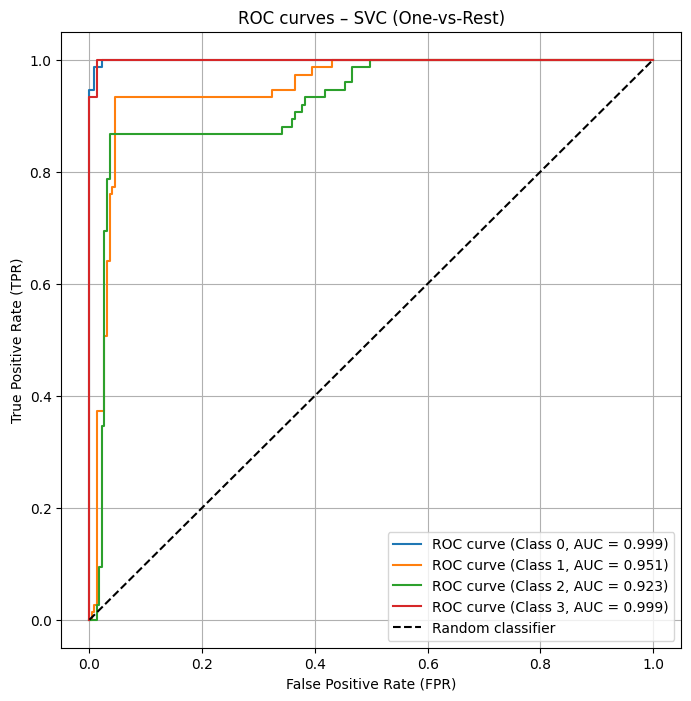

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


#Dane: prawdziwe etykiety i predykcje
# UWAGA: predykcje muszą być prawdopodobieństwami! (np. model.predict_proba)
# For SVC, decision_function returns the distance of each sample to the hyperplane for each class.
# can be used as a score.

y_true = y_test
y_scores = svc_clf.decision_function(X_test_scaled) # for SVC

# Number of classes
n_classes = y_scores.shape[1]

# Binarize y_true for One-vs-Rest ROC
y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))

# --- 2. Wyliczamy FPR, TPR i AUC dla każdej klasy ---
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- 3. Rysunek ---
plt.figure(figsize=(8,8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (Class {i}, AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC curves – SVC (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()